# CNN in Python

Code and notebook written by Eric Reber and Gregor Kajda, \
Center of Computing in Science Education

In this notebook we present flexible and readable python code for a CNN implemented with NumPy. We will present the code, showcase how to use the codebase and fit a CNN that yields a 99% accuracy on the 28x28 MNIST dataset within reasonable time.

The CNN can be used with all schedulers, cost functions and activation functions presented in  https://github.com/EricEReber/Neural-Network/blob/dev/notebook/Neural-Network.ipynb, which we will also showcase in this notebook before the CNN.

The CNN code consists of different types of Layer classes, including Convolution2DLayer, Pooling2DLayer, FlattenLayer, FullyConnectedLayer and OutputLayer, which can be added to the CNN object using the interface of the CNN class. This allows students to easily construct their own CNN, as well as allowing students to get used to an interface similar to that of TensorFlow which is used for real world applications.

Another important feature of this code is that it throws errors if unreasonable decisions are made (for example using a kernel that is larger than the image, not using a FlattenLayer, etc), and provides the user with an informative error message.

List of contents: \
I.   Schedulers \
II.  Activation Functions \
III. Cost Functions \
IV.  Convolution \
V    Layers \
VI   CNN

## I. Schedulers
The code below shows object oriented implementations of the Constant, Momentum, Adagrad, AdagradMomentum, RMS prop and Adam schedulers. All of the classes belong to the shared abstract Scheduler class, and share the update_change() and reset() methods allowing for any of the schedulers to be seamlessly used during the training stage, as will later be shown in the fit() method of the neural network. Update_change() only has one parameter, the gradient ($\delta^{l}_{j}a^{l-1}_k$), and returns the change which will be subtracted from the weights. The reset() function takes no parameters, and resets the desired variables. For Constant and Momentum, reset does nothing.

In [1]:
import autograd.numpy as np

class Scheduler:
    """
    Abstract class for Schedulers
    """

    def __init__(self, eta):
        self.eta = eta

    # should be overwritten
    def update_change(self, gradient):
        raise NotImplementedError

    # overwritten if needed
    def reset(self):
        pass


class Constant(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)

    def update_change(self, gradient):
        return self.eta * gradient
    
    def reset(self):
        pass


class Momentum(Scheduler):
    def __init__(self, eta: float, momentum: float):
        super().__init__(eta)
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        self.change = self.momentum * self.change + self.eta * gradient
        return self.change

    def reset(self):
        pass


class Adagrad(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)
        self.G_t = None

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        return self.eta * gradient * G_t_inverse

    def reset(self):
        self.G_t = None


class AdagradMomentum(Scheduler):
    def __init__(self, eta, momentum):
        super().__init__(eta)
        self.G_t = None
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        self.change = self.change * self.momentum + self.eta * gradient * G_t_inverse
        return self.change

    def reset(self):
        self.G_t = None


class RMS_prop(Scheduler):
    def __init__(self, eta, rho):
        super().__init__(eta)
        self.rho = rho
        self.second = 0.0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero
        self.second = self.rho * self.second + (1 - self.rho) * gradient * gradient
        return self.eta * gradient / (np.sqrt(self.second + delta))

    def reset(self):
        self.second = 0.0


class Adam(Scheduler):
    def __init__(self, eta, rho, rho2):
        super().__init__(eta)
        self.rho = rho
        self.rho2 = rho2
        self.moment = 0
        self.second = 0
        self.n_epochs = 1

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        self.moment = self.rho * self.moment + (1 - self.rho) * gradient
        self.second = self.rho2 * self.second + (1 - self.rho2) * gradient * gradient

        moment_corrected = self.moment / (1 - self.rho**self.n_epochs)
        second_corrected = self.second / (1 - self.rho2**self.n_epochs)

        return self.eta * moment_corrected / (np.sqrt(second_corrected + delta))

    def reset(self):
        self.n_epochs += 1
        self.moment = 0
        self.second = 0

## Usage of schedulers

To initalize a scheduler, simply create the object and pass in the necessary parameters such as the learning rate and the momentum as shown below. As the Scheduler class is an abstract class it should not called directly, and will raise an error upon usage.


In [2]:
momentum_scheduler = Momentum(eta=1e-3, momentum=0.9)
adam_scheduler = Adam(eta=1e-3, rho=0.9, rho2=0.999)

Here is a small example for how a segment of code using schedulers could look. Switching out the schedulers is simple.

In [3]:
weights = np.ones((3,3))
print(f"Before scheduler:\n{weights=}")

epochs = 10
for e in range(epochs):
    gradient = np.random.rand(3, 3)
    change = adam_scheduler.update_change(gradient)
    weights = weights - change
    adam_scheduler.reset()

print(f"\nAfter scheduler:\n{weights=}")

Before scheduler:
weights=array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

After scheduler:
weights=array([[0.99399301, 0.99399303, 0.993993  ],
       [0.99399301, 0.99399302, 0.99399302],
       [0.99399301, 0.99399417, 0.99399302]])


## II. Cost functions

In this section we will quickly look at cost functions that can be used when creating the neural network. Every cost function takes the target vector as its parameter, and returns a function valued only at X such that it may easily be differentiated.


In [4]:
def CostOLS(target):
    """
    Return OLS function valued only at X, so
    that it may be easily differentiated
    """

    def func(X):
        return (1.0 / target.shape[0]) * np.sum((target - X) ** 2)

    return func


def CostLogReg(target):
    """
    Return Logistic Regression cost function
    valued only at X, so that it may be easily differentiated
    """

    def func(X):
        return -(1.0 / target.shape[0]) * np.sum(
            (target * np.log(X + 10e-10)) + ((1 - target) * np.log(1 - X + 10e-10))
        )

    return func


def CostCrossEntropy(target):
    """
    Return cross entropy cost function valued only at X, so
    that it may be easily differentiated
    """
    
    def func(X):
        return -(1.0 / target.size) * np.sum(target * np.log(X + 10e-10))

    return func


## Usage of cost functions

Below we will provide a short example of how these cost function may be used to obtain results if you wish to test them out on your own using AutoGrad's automatic differentiation.


In [5]:
from autograd import grad

target = np.array([[1, 2, 3]]).T
a = np.array([[4, 5, 6]]).T

cost_func = CostCrossEntropy
cost_func_derivative = grad(cost_func(target))

valued_at_a = cost_func_derivative(a)
print(f"Derivative of cost function {cost_func.__name__} valued at a:\n{valued_at_a}")

Derivative of cost function CostCrossEntropy valued at a:
[[-0.08333333]
 [-0.13333333]
 [-0.16666667]]


## III. Activation functions

Finally, before we look at the layers that make up the neural network, we will look at the activation functions which can be specified between the hidden layers and as the output function. Each function can be valued for any given vector or matrix X, and can be differentiated via derivate().


In [6]:
import autograd.numpy as np
from autograd import elementwise_grad

def identity(X):
    return X


def sigmoid(X):
    try:
        return 1.0 / (1 + np.exp(-X))
    except FloatingPointError:
        return np.where(X > np.zeros(X.shape), np.ones(X.shape), np.zeros(X.shape))


def softmax(X):
    X = X - np.max(X, axis=-1, keepdims=True)
    delta = 10e-10
    return np.exp(X) / (np.sum(np.exp(X), axis=-1, keepdims=True) + delta)


def RELU(X):
    return np.where(X > np.zeros(X.shape), X, np.zeros(X.shape))


def LRELU(X):
    delta = 10e-4
    return np.where(X > np.zeros(X.shape), X, delta * X)


def derivate(func):
    if func.__name__ == "RELU":

        def func(X):
            return np.where(X > 0, 1, 0)

        return func

    elif func.__name__ == "LRELU":

        def func(X):
            delta = 10e-4
            return np.where(X > 0, 1, delta)

        return func

    else:
        return elementwise_grad(func)


## Usage of activation functions

Below is a short demonstration of how to use an activation function. The derivative of the activation function will be important when calculating the output delta term during backpropagation. Note that derivate() can also be used for cost functions for a more generalized approach.


In [7]:
z = np.array([[4, 5, 6]]).T
print(f"Input to activation function:\n{z}")

act_func = sigmoid
a = act_func(z)
print(f"\nOutput from {act_func.__name__} activation function:\n{a}")

act_func_derivative = derivate(act_func)
valued_at_z = act_func_derivative(a)
print(f"\nDerivative of {act_func.__name__} activation function valued at z:\n{valued_at_z}")

Input to activation function:
[[4]
 [5]
 [6]]

Output from sigmoid activation function:
[[0.98201379]
 [0.99330715]
 [0.99752738]]

Derivative of sigmoid activation function valued at z:
[[0.19824029]
 [0.19721923]
 [0.19683648]]


## IV. Convolution

In order to construct a convolutional neural network (CNN), it is crucial to comprehend the fundamental principles of convolution and how it aids in extracting information from images. Convolution, at its core, is merely a mathematical operation between two functions that yields another function. It is represented by an integral between two functions, which is typically expressed as:

$$(f \ast g)(t):=\int_{-\infty}^{\infty} f(\tau) g(t-\tau) d \tau$$

Here, f and g are the two functions on which we want to perform an operation. The outcome of the convolution operation is represented by $(f \ast g)$, and it is derived by sliding the function g over f and computing the integral of their product at each position. If both functions are continuous, convolution takes the form shown above. However, if we discretize both f and g, the convolution operation will take the form of a sum between the elements of f and g:


$$(f \ast g)[n]=\sum_{m=0}^{n-1} f[m] g[n-m]$$

The key idea we utilize to extract the information contained in an image is to slide an $m \times n$ matrix *g* over an $m \times n$ matrix *f*. In our case, *f* represents the image, while *g* represents the kernel, oftentimes called a filter. However, since our convolution will be a two-dimensional variant, we need to extend our mathematical formula with an additional summation:


$$(f \ast g)[i, j]\sum_{m=0}^{M-1}\sum_{n=0}^{N-1} f[m,n] g[i-m, j-n]$$

It is imperative to note that the size of the kernel g is significantly smaller than the size of the input image f, thereby reducing the amount of computation necessary for feature extraction. Furthermore, the kernel is usually a trainable parameter in a convolutional neural network, allowing the network to learn appropriate kernels for specific tasks.

Now to give you an example of how 2D convolution works in practice, suppose we have an image *f* of dimension $6 \times 6$

$$
f = \begin{bmatrix}
4 & 1 & 2 & 9 & 8 & 6 \\
9 & 5 & 9 & 5 & 8 & 5 \\
1 & 5 & 9 & 7 & 6 & 4 \\
2 & 9 & 8 & 3 & 7 & 1 \\
8 & 1 & 6 & 4 & 2 & 2 \\
1 & 0 & 5 & 7 & 8 & 2 \\
\end{bmatrix}
$$

and a $3 \times 3$ kernel *g* called a low-pass filter. Note that the kernel is usually rotated by 180 degrees during convolution, however this has no effect on this kernel.

$$g = \frac{1}{9} 
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 \\
\end{bmatrix}
$$

In order to filter the image, we have to extract a $3 \times 3$ element from the upper left corner of *f*, and perform element-wise multiplication of the extracted image pixels with the elements of the kernel *g*:

$$
\begin{bmatrix}
4 & 1 & 2 \\
9 & 5 & 9 \\
1 & 5 & 9 \\ 
\end{bmatrix} 
\cdot
\begin{bmatrix}
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\end{bmatrix}
= 
\begin{bmatrix}
\frac{4}{9} & \frac{1}{9} & \frac{2}{9} \\
\frac{9}{9} & \frac{5}{9} & \frac{9}{9} \\
\frac{1}{9} & \frac{5}{9} & \frac{9}{9} \\
\end {bmatrix}
= \textbf{A}
$$

Then, following the multiplication, we summarize all the elements of the resulting matrix A:

$$
(f \ast g)[0, 0]= \sum_{i=0}^{2} \sum_{j=0}^{2} a_{i,j} = 5
$$

Which corresponds to the first element of the filtered image $(f \ast g)$.

Here we use a stride of 1, a parameter denoted *s* which describes how many indexes we move the kernel *g* to the right before repeating the calculations above for the next $3 \times 3$ element of the image *f*. It is usually presumed that *s*=1, however, larger values for *s* can be used to reduce the dimentionality of the filtered image such that the convolution operation is more computationally efficient. In the context of a convolutional neural network, this will become very useful.

The full result of the convolution is:

$$
(f \ast g) =
\begin{bmatrix}
5 & 5.78 & 7 & 6.44 \\ 
6.33 & 6.67 & 6.89 & 5.11 \\
5.44 & 5.78 & 5.78 & 4 \\
4.44 & 4.78 & 5.56 & 4 \\
\end{bmatrix}
$$

The result is markedly smaller in shape than the original image. This occurs when using convolution without first padding the image with additional columns and rows, allowing us to keep the original image shape after sliding the kernel over the image.
How many rows and columns we wish to pad the image with depends strictly on the shape of the kernel, as we wish to pad the image with *r* additional rows and *c* additional columns.

$$r =\lfloor \frac{kernel\ height}{2} \rfloor \cdot 2 \\
c =\lfloor \frac{kernel\ width}{2} \rfloor \cdot 2$$

Note the notation $\lfloor \frac{kernel width}{2} \rfloor$ means that we floor the result of the division, meaning we round down to a whole number in case $\frac{kernel width}{2}$ results in a floating point number.

Using those simple equations, we find out by how much we have to extend the dimensions of the original image. Before proceeding, however, we might ask what we shall fill the additional rows and columns with? One of the most common approaches to padding is zero-padding, which as the name suggest, involves filling the rows and columns with zeros. This is the approach that we will be using for this demonstration. If we apply this padding to out original 6 x 6 image, the result will we an 8 x 8 image as the kernel has a width and height of 3. Note that the original image is encapsuled by the zero-padded rows and columns: 

\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 4 & 1 & 2 & 9 & 8 & 6 & 0 \\
0 & 9 & 5 & 9 & 5 & 8 & 5 & 0 \\
0 & 1 & 5 & 9 & 7 & 6 & 4 & 0 \\
0 & 2 & 9 & 8 & 3 & 7 & 1 & 0 \\
0 & 8 & 1 & 6 & 4 & 2 & 2 & 0 \\
0 & 1 & 0 & 5 & 7 & 8 & 2 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}

Below we have provided code that demonstrates padding and convolution. As you will see when we run the code, the size of the image will remain unchanged when using padding.

In [35]:
import numpy as np

def padding(image, kernel):
    # calculate r and c
    r = (kernel.shape[0] // 2) * 2
    c = (kernel.shape[1] // 2) * 2
    
    # padded image dimensions
    padded_height = image.shape[0] + r
    padded_width = image.shape[1] + c
    
    # for more readable code
    k_half_height = kernel.shape[0] // 2
    k_half_width = kernel.shape[1] // 2

    # zero matrix with padded dimensions
    padded_img = np.zeros((padded_height, padded_width))

    # place image into zero matrix
    padded_img[k_half_height : padded_height - k_half_height,
               k_half_width : padded_width - k_half_width] = image[:, :]

    return padded_img

def convolve(original_image, padded_image, kernel, stride=1):
    # rotate kernel by 180 degrees
    kernel = np.rot90(np.rot90(kernel))

    # note that kernel height // 2 is written as 'm'
    # and kernel width // 2 as 'n' in the mathematical notation
    m = kernel.shape[0] // 2
    n = kernel.shape[1] // 2
    
    r = (kernel.shape[0] // 2) * 2
    c = (kernel.shape[1] // 2) * 2
    
    # initialize output array
    convolved_image = np.zeros(original_image.shape)
    image_height = original_image.shape[0]
    image_width = original_image.shape[1]

    # the convolution
    for i in range(m, image_height + m, stride):
        for j in range(n, image_width + n, stride):
            convolved_image[i-m, j-n] = np.sum(
                padded_image[i : i + m, j : j + n]
                * kernel
            )
            
    return convolved_image

def convolve(image, kernel, stride=1):
    for i in range(2):
        kernel = np.rot90(kernel)

    k_half_height = kernel.shape[0] // 2
    k_half_width = kernel.shape[0] // 2

    conv_image = np.zeros(image.shape)
    pad_image = padding(image, kernel)

    for i in range(k_half_height, conv_image.shape[0] + k_half_height, stride):
        for j in range(k_half_width, conv_image.shape[1] + k_half_width, stride):
            conv_image[i - k_half_height, j - k_half_width] = np.sum(
                pad_image[
                    i - k_half_height : i + k_half_height + 1, j - k_half_width : j + k_half_width + 1
                ]
                * kernel
            )

    return conv_image

Fun fact: When filtering images, you will see that convolution involves rotating the kernel by 180 degrees. 
However, this is not the case when applying convolution in a CNN, where the same operation not rotated by 180 degrees is called 
cross-correlation.

In [37]:
original_image = np.array([[4, 1, 2, 9, 8, 6],
                 [9, 5, 9, 5, 8, 5],
                 [1, 5, 9, 7, 6, 4],
                 [2, 9, 8, 3, 7, 1],
                 [8, 1, 6, 4, 2, 2],
                 [1, 0, 5, 7, 8, 2]])

kernel = (1/9)*np.ones((3,3))

print(f"{original_image.shape=}")

# note that convolve() performs padding
convolved_image = convolve(original_image, kernel, stride=1)

print(f"{convolved_image.shape=}")

original_image.shape=(6, 6)
convolved_image.shape=(6, 6)


As you can see, the resulting image is of the same size as the original image. To round of our demonstration of convolution, we will present the results of convolution using commonly used kernels. In a CNN, the values of the kernels are randomly initialized, and then learned during training. These kernels will extract information regarding the picture, such as for example the edge detection filter demonstrated below extracts the edges present in the picture. Of course, there is no guarantee that the CNN will learn an edge detection filter, but this should provide some intuiton as to how the CNN is able to use kernels to make better predictions than a regular feed forward neural network.

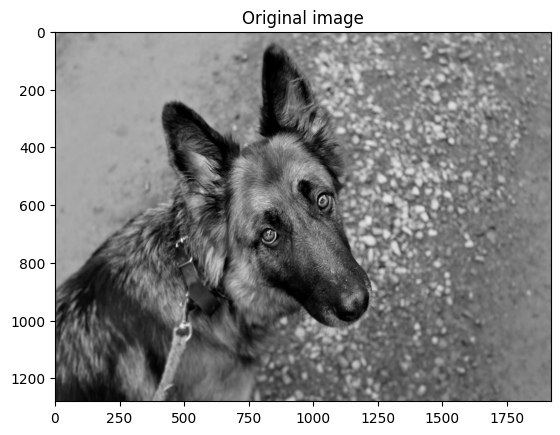

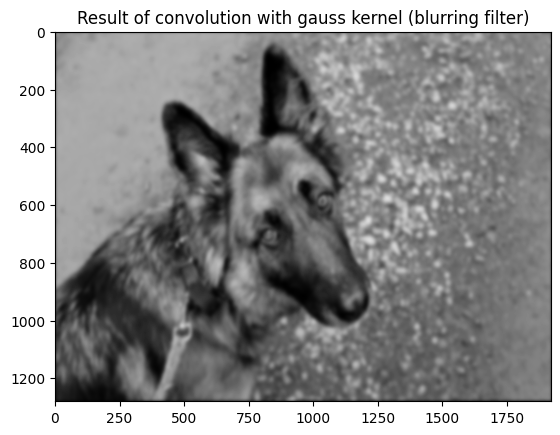

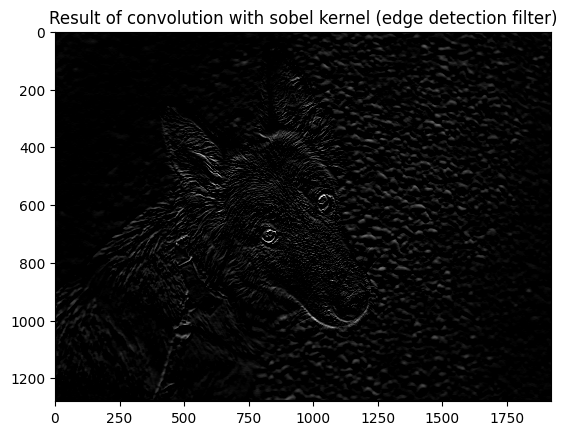

In [38]:
# Now an example using a real image and first a gaussian low-pass filter and then a sobel filter
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import time

def generate_gauss_mask(sigma, K=1):
    side = np.ceil(1 + 8 * sigma)
    y, x = np.mgrid[-side // 2 + 1 : (side // 2) + 1, -side // 2 + 1 : (side // 2) + 1]
    ker_coef = K / (2 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0 * sigma**2)))

    return g, ker_coef


img_path = "../data/IMG-2167.JPG"
image_of_cute_dog = imageio.imread(img_path, mode='L')

plt.imshow(image_of_cute_dog, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.title("Original image")
plt.show()

gauss, kernel = generate_gauss_mask(sigma=6)
gauss_kernel = gauss*kernel

filtered_image = convolve(image_of_cute_dog, gauss_filter)
plt.imshow(filtered_image, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.title("Result of convolution with gauss kernel (blurring filter)")
plt.show()

sobel_kernel = np.array([[1, 2, 1],
                    [0, 0, 0], 
                    [-1, -2, -1]])

filtered_image = conv2D(image_of_cute_dog, sobel_kernel)

plt.imshow(filtered_image, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.title("Result of convolution with sobel kernel (edge detection filter)")
plt.show()

## V. Layers

The code below initialises global variables for readability and describes the abstract class Layers. This is not important in order to understand the CNN, but is benefitial for organizing the code neatly.

In [22]:
import math
import autograd.numpy as np
from copy import deepcopy, copy
from autograd import grad
from typing import Callable

# global variables for index readability
input_index = 0
node_index = 1
bias_index = 1
input_channel_index = 1
feature_maps_index = 1
height_index = 2
width_index = 3
kernel_feature_maps_index = 1
kernel_input_channels_index = 0


class Layer:
    def __init__(self, seed):
        self.seed = seed

    def _feedforward(self):
        raise NotImplementedError

    def _backpropagate(self):
        raise NotImplementedError

    def _reset_weights(self, previous_nodes):
        raise NotImplementedError

### Convolution2DLayer: convolution in a hidden layer

After establishing the foundational understanding of applying convolution to spatial data, let us delve into the intricate workings of a convolutional layer in a Convolutional Neural Network (CNN). The primary function of convolution, as previously discussed, is to extract pertinent information from images while simultaneously decreasing the scale of our data. To initiate the image processing, we shall begin by partitioning the images into color channels (unless the image is grayscale), comprising three primary colors: red, green, and blue. We will subsequently utilize trainable kernels to construct a higher-dimensional encoding of each channel called feature maps. Successive layers will receive these feature maps as inputs, generating further encodings, albeit with reduced dimensions. The term trainable kernels denotes the initialization of pre-defined kernel-shaped weights, which we will then train via backpropagation, similar to how weights are trained in a Feedforward Neural Network.

To ensure seamless integration between our implementation of the convolutional layer and popular machine learning frameworks like Tensorflow (Keras) and PyTorch, we have adopted a design pattern that mirrors the construction of models using these APIs. This involves implementing our convolutional layer as a Python class or object, which allows for a more modular and flexible approach to building neural networks. By structuring our code in this way, users can easily incorporate our implementation into their existing machine learning pipelines without having to make significant changes to their codebase. Additionally, this design pattern promotes code reusability and makes it easier to maintain and update our convolutional layer implementation over time.

In [28]:
class Convolution2DLayer(Layer):
    def __init__(
        self,
        input_channels,
        feature_maps,
        kernel_height,
        kernel_width,
        v_stride,
        h_stride,
        pad,
        act_func: Callable,
        seed=None,
        reset_self=True,
    ):
        super().__init__(seed)
        self.input_channels = input_channels
        self.feature_maps = feature_maps
        self.kernel_height = kernel_height
        self.kernel_width = kernel_width
        self.v_stride = v_stride
        self.h_stride = h_stride
        self.pad = pad
        self.act_func = act_func

        # such that the layer can be used on its own
        # outside of the CNN module
        if reset_self == True:
            self._reset_weights_single_layer()

    def _reset_weights_single_layer(self):
        # sets seed to remove randomness inbetween runs
        if self.seed is not None:
            np.random.seed(self.seed)

        # initializes kernel matrix
        self.kernel = np.ndarray(
            (
                self.input_channels,
                self.feature_maps,
                self.kernel_height,
                self.kernel_width,
            )
        )

        # randomly initializes weights
        for chin in range(self.kernel.shape[kernel_input_channels_index]):
            for fmap in range(self.kernel.shape[kernel_feature_maps_index]):
                self.kernel[chin, fmap, :, :] = np.random.rand(
                    self.kernel_height, self.kernel_width
                )

    def _reset_weights(self, previous_nodes):
        # sets weights
        self._reset_weights_single_layer()

        # returns shape of output used for subsequent layer's weight initiation
        strided_height = int(
            np.ceil(previous_nodes.shape[height_index] / self.v_stride)
        )
        strided_width = int(np.ceil(previous_nodes.shape[width_index] / self.h_stride))
        next_nodes = np.ones(
            (
                previous_nodes.shape[input_index],
                self.feature_maps,
                strided_height,
                strided_width,
            )
        )
        return next_nodes / self.kernel_height

    def _feedforward(self, X_batch):
        # note that the shape of X_batch = [batch_size, input_maps, img_height, img_width]

        # pad the input batch
        X_batch_padded = self._padding(X_batch)

        # calculate height_index and width_index after stride
        strided_height = int(np.ceil(X_batch.shape[height_index] / self.v_stride))
        strided_width = int(np.ceil(X_batch.shape[width_index] / self.h_stride))

        # create output array
        output = np.ndarray(
            (
                X_batch.shape[input_index],
                self.feature_maps,
                strided_height,
                strided_width,
            )
        )

        # save input and output for backpropagation
        self.X_batch_feedforward = X_batch
        self.output_shape = output.shape

        # checking for errors, no need to look here :)
        self._check_for_errors()

        # convolve input with kernel
        for img in range(X_batch.shape[input_index]):
            for chin in range(self.input_channels):
                for fmap in range(self.feature_maps):
                    out_h = 0
                    for h in range(0, X_batch.shape[height_index], self.v_stride):
                        out_w = 0
                        for w in range(0, X_batch.shape[width_index], self.h_stride):
                            output[img, fmap, out_h, out_w] = np.sum(
                                X_batch_padded[
                                    img,
                                    chin,
                                    h : h + self.kernel_height,
                                    w : w + self.kernel_width,
                                ]
                                * self.kernel[chin, fmap, :, :]
                            )
                            out_w += 1
                        out_h += 1

        # Pay attention to the fact that we're not rotating the kernel by 180 degrees when filtering the image in
        # the convolutional layer, as convolution in terms of Machine Learning is a procedure known as cross-correlation
        # in image processing and signal processing

        # return a
        return self.act_func(output / (self.kernel_height))

    def _backpropagate(self, delta_term_next):
        # intiate matrices
        delta_term = np.zeros((self.X_batch_feedforward.shape))
        gradient_kernel = np.zeros((self.kernel.shape))

        # pad input for convolution
        X_batch_padded = self._padding(self.X_batch_feedforward)

        # Since an activation function is used at the output of the convolution layer, its derivative
        # has to be accounted for in the backpropagation -> as if ReLU was a layer on its own.
        act_derivative = derivate(self.act_func)
        delta_term_next = act_derivative(delta_term_next)

        if self.v_stride > 1:
            v_ind = 1
            for i in range(delta_term_next.shape[height_index]):
                for j in range(self.v_stride - 1):
                    delta_term_next = np.insert(
                        delta_term_next, v_ind, 0, axis=height_index
                    )
                v_ind += self.v_stride

        if self.h_stride > 1:
            h_ind = 1
            for i in range(delta_term_next.shape[width_index]):
                for k in range(self.h_stride - 1):
                    delta_term_next = np.insert(
                        delta_term_next, v_ind, 0, axis=width_index
                    )
                h_ind += self.h_stride

            # crops out 0-rows and 0-columns
        delta_term_next = delta_term_next[
            :,
            :,
            : self.X_batch_feedforward.shape[height_index],
            : self.X_batch_feedforward.shape[width_index],
        ]

        # The gradient received from the next layer also needs to be padded
        delta_term_next = self._padding(delta_term_next)

        # calculate delta term by convolving next delta term with kernel
        for img in range(self.X_batch_feedforward.shape[input_index]):
            for chin in range(self.input_channels):
                for fmap in range(self.feature_maps):
                    for h in range(self.X_batch_feedforward.shape[height_index]):
                        for w in range(self.X_batch_feedforward.shape[width_index]):
                            delta_term[img, chin, h, w] = np.sum(
                                delta_term_next[
                                    img,
                                    fmap,
                                    h : h + self.kernel_height,
                                    w : w + self.kernel_width,
                                ]
                                * np.rot90(np.rot90(self.kernel[chin, fmap, :, :]))
                            )

        # calculate gradient for kernel for weight update
        # also via convolution
        for chin in range(self.input_channels):
            for fmap in range(self.feature_maps):
                for k_x in range(self.kernel_height):
                    for k_y in range(self.kernel_width):
                        gradient_kernel[chin, fmap, k_x, k_y] = np.sum(
                            X_batch_padded[
                                img,
                                chin,
                                h : h + self.kernel_height,
                                w : w + self.kernel_width,
                            ]
                            * delta_term_next[
                                img,
                                fmap,
                                h : h + self.kernel_height,
                                w : w + self.kernel_width,
                            ]
                        )
        # all kernels are updated with weight gradient of kernel
        self.kernel -= gradient_kernel

        # return delta term
        return delta_term

    def _padding(self, X_batch, batch_type="image"):

        if self.pad == "same" and batch_type == "image":
            padded_height = X_batch.shape[height_index] + (self.kernel_height // 2) * 2
            padded_width = X_batch.shape[width_index] + (self.kernel_width // 2) * 2
            half_kernel_height = self.kernel_height // 2
            half_kernel_width = self.kernel_width // 2

            new_tensor = np.ndarray(
                (
                    X_batch.shape[input_index],
                    X_batch.shape[feature_maps_index],
                    padded_height,
                    padded_width,
                )
            )

            for img in range(X_batch.shape[input_index]):
                padded_img = np.zeros(
                    (X_batch.shape[feature_maps_index], padded_height, padded_width)
                )
                padded_img[
                    :,
                    half_kernel_height : padded_height - half_kernel_height,
                    half_kernel_width : padded_width - half_kernel_width,
                ] = X_batch[img, :, :, :]
                new_tensor[img, :, :, :] = padded_img[:, :, :]

            return new_tensor

        elif self.pad == "same" and batch_type == "grad":
            padded_height = X_batch.shape[height_index] + (self.kernel_height // 2) * 2
            padded_width = X_batch.shape[width_index] + (self.kernel_width // 2) * 2
            half_kernel_height = self.kernel_height // 2
            half_kernel_width = self.kernel_width // 2

            new_tensor = np.zeros(
                (
                    X_batch.shape[input_index],
                    X_batch.shape[feature_maps_index],
                    padded_height,
                    padded_width,
                )
            )

            new_tensor[
                :, :, : X_batch.shape[height_index], : X_batch.shape[width_index]
            ] = X_batch[:, :, :, :]

            return new_tensor

        else:
            return X_batch
        
    def _check_for_errors(self):
        if self.X_batch_feedforward.shape[input_channel_index] != self.input_channels:
            raise AssertionError(
                f"ERROR: Number of input channels in data ({self.X_batch_feedforward.shape[input_channel_index]}) is not equal to input channels in Convolution2DLayerOPT ({self.input_channels})! Please change the number of input channels of the Convolution2DLayer such that they are equal"
            )


### Backpropagation in the convolutional layer

As you may have noticed, we have not yet explained how the backpropagation algorithm works in a convolutional layer. However, having covered all other major details about convolutional layers, we are now prepared to do so. It should come as no surprise that the calculation of delta terms at each convolutional layer takes the form of convolution. After the gradient has been propagated backwards through the flattening layer, where it was reshaped into an appropriate form, calculating the update value for the kernel is simply a matter of convolving the output gradient with the input of the layer for which we are updating the weights. For more detail, this article serves as an excellent resource https://pavisj.medium.com/convolutions-and-backpropagations-46026a8f5d2c

### Demonstration
We can use the convolutional layer above to perform a simple convolution on an image of the now familiar cute dog.

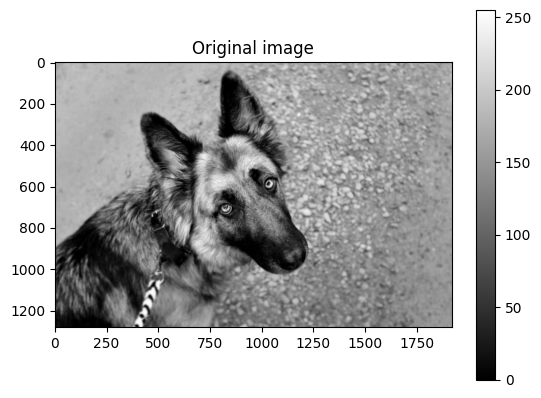

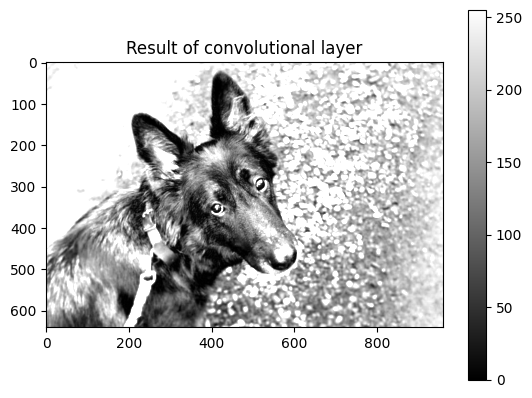

In [41]:
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt

def plot_convolution_result(X, layer):
    plt.imshow(X[0, 0, :, :], vmin=0, vmax=255, cmap="gray")
    plt.title("Original image")
    plt.colorbar()
    plt.show()
    conv_result = layer._feedforward(X)
    plt.title("Result of convolutional layer")
    plt.imshow(conv_result[0, 0, :, :], vmin=0, vmax=255, cmap="gray")
    plt.colorbar()
    plt.show()

# create layer
layer = Convolution2DLayer(
    input_channels=3,
    feature_maps=1,
    kernel_height=4,
    kernel_width=4,
    v_stride=2,
    h_stride=2,
    pad="same",
    act_func=identity,
    seed=2023,
    )

# read in image path, make data correct format
img_path = img_path = "../data/IMG-2167.JPG"
image_of_cute_dog = imageio.imread(img_path)
image_shape = image_of_cute_dog.shape
image_of_cute_dog = image_of_cute_dog.reshape(1, image_shape[0], image_shape[1], image_shape[2])
image_of_cute_dog = image_of_cute_dog.transpose(0, 3, 1, 2)

# plot the result of the convolution
plot_convolution_result(image_of_cute_dog, layer)


From the images, you can see that the result has half the pixels on each axis due to the fact that we've used a horizontal and vertical stride of 2. The result of this convolution is not very insightfull, as the kernel has completely random values for the first feedforward pass. However, as we perform multiple forward and backward passes, the results of the convolution should provide identifying features of the image it uses for classification.

Note that image data usually comes in many different shapes and sizes, but for our CNN we require the input data be formatted as \[Number of inputs, input channels, input height, input width\]. Occasionally, the data you come accross use will be formatted like this, but on many occasions reshaping and transposing the dimensions is sadly necessary.

## Pooling Layer 

The pooling layer is another widely used type of layer in convolutional neural networks that enables data downsampling to a more manageable size. Despite recent technological advancements that allow for convolution without excessive size reduction of the data, the pooling layer still remains a fundamental component of convolutional neural networks. It can be used before, after, or in between convolutional layers, although finding the optimal placement of layers and network depth requires experimentation to achieve the best performance for a given problem. The code we provide allows you to perform two types of pooling known as max pooling and average pooling.

Below is the code for the pooling layer:

In [42]:
class Pooling2DLayer(Layer):
    def __init__(
        self,
        kernel_height,
        kernel_width,
        v_stride,
        h_stride,
        pooling="max",
        seed=None,
    ):
        super().__init__(seed)
        self.kernel_height = kernel_height
        self.kernel_width = kernel_width
        self.v_stride = v_stride
        self.h_stride = h_stride
        self.pooling = pooling

    def _feedforward(self, X_batch):
        # Saving the input for use in the backwardpass
        self.X_batch_feedforward = X_batch

        # check if user is silly
        self._check_for_errors()

        # Computing the size of the feature maps based on kernel size and the stride parameter
        strided_height = (
            X_batch.shape[height_index] - self.kernel_height
        ) // self.v_stride + 1
        if X_batch.shape[height_index] == X_batch.shape[width_index]:
            strided_width = strided_height
        else:
            strided_width = (
                X_batch.shape[width_index] - self.kernel_width
            ) // self.h_stride + 1

        # initialize output array
        output = np.ndarray(
            (
                X_batch.shape[input_index],
                X_batch.shape[feature_maps_index],
                strided_height,
                strided_width,
            )
        )

        # select pooling action, either max or average pooling
        if self.pooling == "max":
            self.pooling_action = np.max
        elif self.pooling == "average":
            self.pooling_action = np.mean

        # pool based on kernel size and stride
        for img in range(output.shape[input_index]):
            for fmap in range(output.shape[feature_maps_index]):
                for h in range(strided_height):
                    for w in range(strided_width):
                        output[img, fmap, h, w] = self.pooling_action(
                            X_batch[
                                img,
                                fmap,
                                (h * self.v_stride) : (h * self.v_stride)
                                + self.kernel_height,
                                (w * self.h_stride) : (w * self.h_stride)
                                + self.kernel_width,
                            ]
                        )

        # output for feedforward in next layer
        return output

    def _backpropagate(self, delta_term_next):
        # initiate delta term array
        delta_term = np.zeros((self.X_batch_feedforward.shape))

        for img in range(delta_term_next.shape[input_index]):
            for fmap in range(delta_term_next.shape[feature_maps_index]):
                for x in range(0, delta_term_next.shape[height_index], self.v_stride):
                    for y in range(
                        0, delta_term_next.shape[width_index], self.h_stride
                    ):
                        # max pooling
                        if self.pooling == "max":
                            window = self.X_batch_feedforward[
                                img,
                                fmap,
                                x : x + self.kernel_height,
                                y : y + self.kernel_width,
                            ]

                            # TODO window_h and window_w?
                            i, j = np.unravel_index(window.argmax(), window.shape)

                            delta_term[
                                img,
                                fmap,
                                (x + i),
                                (y + j),
                            ] += delta_term_next[img, fmap, x, y]

                        # average pooling
                        if self.pooling == "average":
                            delta_term[
                                img,
                                fmap,
                                x : x + self.kernel_height,
                                y : y + self.kernel_width,
                            ] = (
                                delta_term_next[img, fmap, h, w]
                                / self.kernel_height
                                / self.kernel_width
                            )
        # returns input to backpropagation in previous layer
        return delta_term

    def _reset_weights(self, previous_nodes):
        # calculate strided height, strided width
        strided_height = (
            previous_nodes.shape[height_index] - self.kernel_height
        ) // self.v_stride + 1
        if previous_nodes.shape[height_index] == previous_nodes.shape[width_index]:
            strided_width = strided_height
        else:
            strided_width = (
                previous_nodes.shape[width_index] - self.kernel_width
            ) // self.h_stride + 1

        # initiate output array
        output = np.ones(
            (
                previous_nodes.shape[input_index],
                previous_nodes.shape[feature_maps_index],
                strided_height,
                strided_width,
            )
        )

        # returns output with shape used for reset weights in next layer
        return output


## Flattening Layer

Before we can begin building our first CNN model, we need to introduce the flattening layer. As its name suggests, the flattening layer transforms the data into a one-dimensional vector that can be fed into the feedforward layers of our network. This layer plays a crucial role in preparing the data for further processing in the network. Additionally, the flattening layer is responsible for reshaping the gradient to the proper shape during backpropagation. This ensures that the kernels are correctly updated, allowing for effective learning in the network.

In [ ]:
class FlattenLayer(Layer):
    def __init__(self, act_func=LRELU, seed=None):
        super().__init__(seed)
        self.act_func = act_func

    def _feedforward(self, X_batch):
        # save input for backpropagation
        self.X_batch_feedforward_shape = X_batch.shape
        # Remember, the data has the following shape: (B, FM, H, W, ) in the convolutional layers
        # whilst the data has the shape (B, FM * H * W) in the fully connected layers
        # FM = Feature maps, B = Batch size, H = Height and W = Width
        X_batch = X_batch.reshape(
            X_batch.shape[input_index],
            X_batch.shape[feature_maps_index]
            * X_batch.shape[height_index]
            * X_batch.shape[width_index],
        )

        # add bias to a
        self.z_matrix = X_batch
        bias = np.ones((X_batch.shape[input_index], 1)) * 0.01
        self.a_matrix = np.hstack([bias, X_batch])

        # return a, the input to feedforward in next layer
        return self.a_matrix

    def _backpropagate(self, weights_next, delta_term_next):
        activation_derivative = derivate(self.act_func)

        # calculate delta term
        delta_term = (
            weights_next[bias_index:, :] @ delta_term_next.T
        ).T * activation_derivative(self.z_matrix)

        # FlattenLayer does not update weights
        # reshapes delta layer to convolutional layer data format [Input, Feature_Maps, Height, Width]
        return delta_term.reshape(self.X_batch_feedforward_shape)

    def get_prev_a(self):
        return self.a_matrix

    def _reset_weights(self, previous_nodes):
        # note that the previous nodes to the FlattenLayer are from the convolutional layers
        previous_nodes = previous_nodes.reshape(
            previous_nodes.shape[input_index],
            previous_nodes.shape[feature_maps_index]
            * previous_nodes.shape[height_index]
            * previous_nodes.shape[width_index],
        )

        # return shape used in reset_weights in next layer
        return previous_nodes.shape[node_index]


## Fully Connected Layers

TODO: WRITE HERE

EVERYTHING UNDER THIS MODULE IS NOT QUALITY CONTROLLED

## Remarks about stride and kernel size 

The stride parameter controls the distance between each convolution and the kernel/filter. If our image is padded, stride is the only parameter that determines the size of the output from a convolutional layer. However, if we decide not to perform any padding, the size of the output feature map depends on both the stride and kernel size. It is important to note that neither the stride nor the kernel has to be symmetrical. This means that we can use a rectangular filter if we choose, and the stride in the vertical direction (axis=0 in Python) does not need to be the same as the stride in the horizontal direction (axis=1 in Python). It may even be the case that asymmetric combinations of stride or kernel dimensions, or both, yield better results than symmetric values for these parameters.

## Remarks on the speed 

Despite our naive convolution algorithm working pretty fine, it is extremely sluggish, requiring approximately 20-30 seconds to process a single image. The time complexity of 2D convolution, which is O(NMnm), rapidly becomes a constraint and may, at worst, make computations infeasible. Consequently, optimizing the naive 2D convolution algorithm is a necessity, as the execution time of the algorithm significantly increases as the input data size expands. This can pose a bottleneck in applications that necessitate real-time processing of large data volumes, such as image and video processing, deep learning, and scientific simulations.

To address this issue, we shall present two widely used optimization techniques: the separable kernel approach and Fast Fourier Transform (FFT). Both of these methods can drastically reduce the computational complexity of convolution and enhance the overall efficiency of processing substantial data quantities. While we shall refrain from delving into the intricacies of these algorithms, we strongly encourage you to examine at least the application of FFT to optimize computations.

## Convolution using separable kernels

Time taken for convolution with seperated kernel on 128x128 image 30.327766180038452


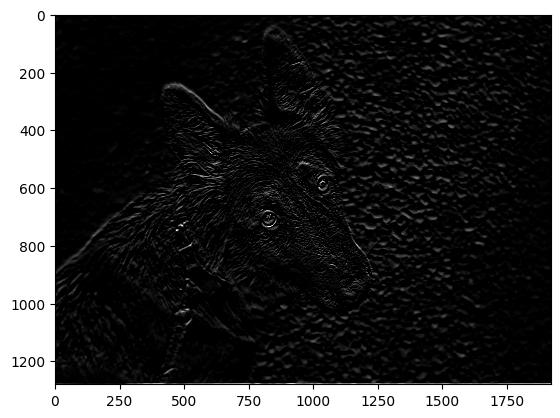

In [11]:

def conv2DSep(image, kernel, coef, stride=1, pad="zero"):
    for i in range(2):
        kernel = np.rot90(kernel)

    # The kernel is quadratic, thus we only need one of its dimensions
    half_dim = kernel.shape[0] // 2

    ker1 = np.array(kernel[0, :])
    ker2 = np.array(kernel[:, 0])

    if pad == "zero":
        conv_image = np.zeros(image.shape)
        pad_image = padding(image, kernel)
    else:
        conv_image = np.zeros(
            (image.shape[0] - kernel.shape[0], image.shape[1] - kernel.shape[1])
        )
        pad_image = image[:, :]

    for i in range(half_dim, conv_image.shape[0] + half_dim, stride):
        for j in range(half_dim, conv_image.shape[1] + half_dim, stride):
            conv_image[i - half_dim, j - half_dim] = (
                pad_image[
                    i - half_dim : i + half_dim + 1, j - half_dim : j + half_dim + 1
                ]
                @ ker1
                @ ker2.T
                * coef
            )

    return conv_image

start_time = time.time()
filtered_image = conv2DSep(image_of_cute_dog, kernel=sobel_y, coef=1)
print(f'Time taken for convolution with seperated kernel on 128x128 image {time.time() - start_time}')
plt.imshow(filtered_image, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.show()


By taking advantage of the capabilities of separable kernels, we can effectively cut the computational expense of filtering an image in half. Yet, if we seek even more rapid processing, we can turn to the Fast Fourier Transform (FFT) algorithm provided by the numpy library. By utilizing FFT to transform the input image and filter into the frequency domain, we can perform convolution in this domain. This approach significantly reduces the number of operations needed and results in a marked speedup relative to other convolution techniques. In addition, it is worth noting that the FFT is widely regarded as one of the most critical algorithms developed to date, with applications ranging from digital signal processing to scientific computing.

## Convolution in the Fourier domain

Time take for convolution in the fourier domain: 0.9284932613372803


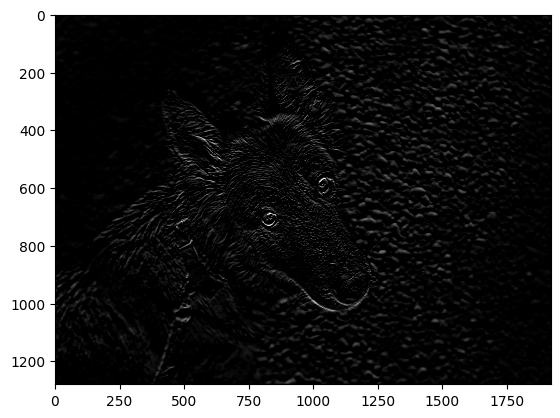

In [12]:
start_time = time.time()
img_fft = np.fft.fft2(image_of_cute_dog)
kernel_fft = np.fft.fft2(sobel_y, s=image_of_cute_dog.shape)

conv_image = img_fft * kernel_fft

filtered_image = np.fft.ifft2(conv_image)
print(f'Time take for convolution in the fourier domain: {time.time() - start_time}')
plt.imshow(filtered_image.real, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.show()



It is evident that executing convolution in the Fourier domain yields the quickest computation time. Nonetheless, one should exercise caution, particularly when dealing with images of relatively small dimensions, as one of the other methods may prove to be more expeditious than FFT-enhanced convolution. The overhead involved in transferring both the image and filter into the Fourier domain, followed by their subsequent transformation back into the spatial domain, results in a minor inconvenience. Therefore, it is imperative to remain cognizant of this fact when utilizing FFT as the primary optimization technique.

The layers will usually be used within the CNN class rather than on their own. If one wishes to construct a regular feed forward neural network using these layers, it would have to start from the FlattenLayer due to technical details regarding the weight initiation.

## IV The Layers

Now that we have a good understanding of the components used in the CNN, we will take a look at how the various layers are used in the CNN, including Convolution2DLayer, Convolution2DLayerOPT (and optimized version of the Convoltuion2DLayer, Pooling2DLayer, FlattenLayer, FullyConnectedLayer and OutputLayer, which can be used to make custom convolutional neural networks. 

## Usage of layers

The layers will usually be used within the CNN class rather than on their own. If one wishes to construct a regular feed forward neural network using these layers, it would have to start from the FlattenLayer due to technical details regarding the weight initiation.

For Convolution2DLayer, we have specifically implemented a weight initiation such that it can be used on its own such that we can better visualize convolution.

From the images, you can see that the result has half the pixels on each axis due to the fact that we've used a horizontal and vertical stride of 2. We can also see that the convolutional layer has to some degree seperated the dog from the background, which will be useful later for the classifier.

Note that image data usually comes in many different shapes and sizes, but for our CNN we require the input data be formatted as \[Number of inputs, input channels, input height, input width\]. Occasionally, the data you come accross use will be formatted like this, but on many occasions reshaping and transposing the dimensions is sadly necessary.

## The Convolutional Neural Network (CNN)

Finally, we will present the code for the CNN. The CNN class organizes all the layers, and allows for training on image data.

In [14]:
import math
import autograd.numpy as np
import sys
import warnings
from src.Schedulers import *
from src.activationFunctions import *
from src.costFunctions import *
from src.Layers import *
from autograd import grad, elementwise_grad
from random import random, seed
from copy import deepcopy
from typing import Tuple, Callable
from sklearn.utils import resample
from collections import OrderedDict


warnings.simplefilter("error")


class CNN:
    def __init__(
        self,
        cost_func: Callable = CostCrossEntropy,
        scheduler: Scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999),
        seed: int = None,
    ):
        """
        Description:
        ------------
            Instantiates CNN object

        Parameters:
        ------------
            I   output_func (costFunctions) cost function for feed forward neural network part of CNN,
                such as "CostLogReg", "CostOLS" or "CostCrossEntropy"

            II  scheduler (Scheduler) optional parameter, default set to Adam. Can also be set to other
                schedulers such as AdaGrad, Momentum, RMS_prop and Constant. Note that schedulers have
                to be instantiated first with proper parameters (for example eta, rho and rho2 for Adam)

            III seed (int) used for seeding all random operations
        """
        self.layers = list()
        self.cost_func = cost_func
        self.scheduler = scheduler
        self.schedulers_weight = list()
        self.schedulers_bias = list()
        self.seed = seed
        self.pred_format = None

    def add_FullyConnectedLayer(
        self, nodes: int, act_func=LRELU, scheduler=None
    ) -> None:
        """
        Description:
        ------------
            Add a FullyConnectedLayer to the CNN, i.e. a hidden layer in the feed forward neural
            network part of the CNN. Often called a Dense layer in literature

        Parameters:
        ------------
            I   nodes (int) number of nodes in FullyConnectedLayer
            II  act_func (activationFunctions) activation function of FullyConnectedLayer,
                such as "sigmoid", "RELU", "LRELU", "softmax" or "identity"
            III scheduler (Scheduler) optional parameter, default set to Adam. Can also be set to other
                schedulers such as AdaGrad, Momentum, RMS_prop and Constant
        """
        assert self.layers, "FullyConnectedLayer should follow FlattenLayer in CNN"

        if scheduler is None:
            scheduler = self.scheduler

        layer = FullyConnectedLayer(nodes, act_func, scheduler, self.seed)
        self.layers.append(layer)

    def add_OutputLayer(self, nodes: int, output_func=sigmoid, scheduler=None) -> None:
        """
        Description:
        ------------
            Add an OutputLayer to the CNN, i.e. a the final layer in the feed forward neural
            network part of the CNN

        Parameters:
        ------------
            I   nodes (int) number of nodes in OutputLayer. Set nodes=1 for binary classification and
                nodes = number of classes for multi-class classification
            II  output_func (activationFunctions) activation function for the output layer, such as
                "identity" for regression, "sigmoid" for binary classification and "softmax" for multi-class
                classification
            III scheduler (Scheduler) optional parameter, default set to Adam. Can also be set to other
                schedulers such as AdaGrad, Momentum, RMS_prop and Constant
        """
        assert self.layers, "OutputLayer should follow FullyConnectedLayer in CNN"

        if scheduler is None:
            scheduler = self.scheduler

        output_layer = OutputLayer(
            nodes, output_func, self.cost_func, scheduler, self.seed
        )
        self.layers.append(output_layer)
        self.pred_format = output_layer.get_pred_format()

    def add_FlattenLayer(self, act_func=LRELU) -> None:
        """
        Description:
        ------------
            Add a FlattenLayer to the CNN, which flattens the image data such that it is formatted to
            be used in the feed forward neural network part of the CNN
        """
        self.layers.append(FlattenLayer(act_func=act_func, seed=self.seed))

    def add_Convolution2DLayer(
        self,
        input_channels=1,
        feature_maps=3,
        kernel_height=32,
        kernel_width=32,
        v_stride=1,
        h_stride=1,
        pad="same",
        act_func=LRELU,
        optimized=True,
    ) -> None:
        """
        Description:
        ------------
            Add a Convolution2DLayer to the CNN, i.e. a convolutional layer with a 2 dimensional kernel. Should be
            the first layer added to the CNN

        Parameters:
        ------------
            I   input_channels (int) specifies amount of input channels. For monochrome images, use input_channels
                = 1, and input_channels = 3 for colored images, where each channel represents one of R, G and B
            II  feature_maps (int) amount of feature maps in CNN
            III kernel_height (int) height of the kernel, also called 'convolutional filter' in literature
            IV  kernel_width (int) width of the kernel, also called 'convolutional filter' in literature
            V   v_stride (int) value of vertical stride for dimentionality reduction
            VI  h_stride (int) value of horizontal stride for dimentionality reduction
            VII pad (str) default = "same" ensures output size is the same as input size (given stride=1)
           VIII act_func (activationFunctions) default = "LRELU", nonlinear activation function
             IX optimized (bool) default = True, uses Convolution2DLayerOPT if True which is much faster when
                compared to Convolution2DLayer, which is a more straightforward, understandable implementation
        """
        if optimized:
            conv_layer = Convolution2DLayerOPT(
                input_channels,
                feature_maps,
                kernel_height,
                kernel_width,
                v_stride,
                h_stride,
                pad,
                act_func,
                self.seed,
                reset_self=False,
            )
        else:
            conv_layer = Convolution2DLayer(
                input_channels,
                feature_maps,
                kernel_height,
                kernel_width,
                v_stride,
                h_stride,
                pad,
                act_func,
                self.seed,
                reset_self=False,
            )
        self.layers.append(conv_layer)

    def add_PoolingLayer(
        self, kernel_height=2, kernel_width=2, v_stride=1, h_stride=1, pooling="max"
    ) -> None:
        """
        Description:
        ------------
            Add a Pooling2DLayer to the CNN, i.e. a pooling layer that reduces the dimentionality of
            the image data. It is not necessary to use a Pooling2DLayer when creating a CNN, but it
            can be used to speed up the training

        Parameters:
        ------------
            I   kernel_height (int) height of the kernel used for pooling
            II  kernel_width (int) width of the kernel used for pooling
            III v_stride (int) value of vertical stride for dimentionality reduction
            IV  h_stride (int) value of horizontal stride for dimentionality reduction
            V   pooling (str) either "max" or "average", describes type of pooling performed
        """
        pooling_layer = Pooling2DLayer(
            kernel_height, kernel_width, v_stride, h_stride, pooling, self.seed
        )
        self.layers.append(pooling_layer)

    def fit(
        self,
        X: np.ndarray,
        t: np.ndarray,
        epochs: int = 100,
        lam: float = 0,
        batches: int = 1,
        X_val: np.ndarray = None,
        t_val: np.ndarray = None,
    ) -> dict:
        """
        Description:
        ------------
            Fits the CNN to input X for a given amount of epochs. Performs feedforward and backpropagation passes,
            can utilize batches, regulariziation and validation if desired.

        Parameters:
        ------------
            X (numpy array) with input data in format [images, input channels,
            image height, image_width]
            t (numpy array) target labels for input data
            epochs (int) amount of epochs
            lam (float) regulariziation term lambda
            batches (int) amount of batches input data splits into
            X_val (numpy array) validation data
            t_val (numpy array) target labels for validation data

        Returns:
        ------------
            scores (dict) a dictionary with "train_error", "train_acc", "val_error", val_acc" keys
            that contain numpy arrays with float values of all accuracies/errors over all epochs.
            Can be used to create plots. Also used to update the progress bar during training
        """

        # setup
        if self.seed is not None:
            np.random.seed(self.seed)

        # initialize weights
        self._initialize_weights(X)

        # create arrays for score metrics
        scores = self._initialize_scores(epochs)

        assert batches <= t.shape[0]
        batch_size = X.shape[0] // batches

        try:
            for epoch in range(epochs):
                for batch in range(batches):
                    # minibatch gradient descent
                    # If the for loop has reached the last batch, take all thats left
                    if batch == batches - 1:
                        X_batch = X[batch * batch_size :, :, :, :]
                        t_batch = t[batch * batch_size :, :]
                    else:
                        X_batch = X[
                            batch * batch_size : (batch + 1) * batch_size, :, :, :
                        ]
                        t_batch = t[batch * batch_size : (batch + 1) * batch_size, :]

                    self._feedforward(X_batch)
                    self._backpropagate(t_batch, lam)

                # reset schedulers for each epoch (some schedulers pass in this call)
                for layer in self.layers:
                    if isinstance(layer, FullyConnectedLayer):
                        layer._reset_scheduler()

                # computing performance metrics
                scores = self._compute_scores(scores, epoch, X, t, X_val, t_val)

                # printing progress bar
                print_length = self._progress_bar(
                    epoch,
                    epochs,
                    scores,
                )
        # allows for stopping training at any point and seeing the result
        except KeyboardInterrupt:
            pass

        # visualization of training progression (similiar to tensorflow progression bar)
        sys.stdout.write("\r" + " " * print_length)
        sys.stdout.flush()
        self._progress_bar(
            epochs,
            epochs,
            scores,
        )
        sys.stdout.write("")

        return scores

    def _feedforward(self, X_batch) -> np.ndarray:
        """
        Description:
        ------------
            Performs the feedforward pass for all layers in the CNN. Called from fit()
        """
        a = X_batch
        for layer in self.layers:
            a = layer._feedforward(a)

        return a

    def _backpropagate(self, t_batch, lam) -> None:
        """
        Description:
        ------------
            Performs backpropagation for all layers in the CNN. Called from fit()
        """
        assert len(self.layers) >= 2
        reversed_layers = self.layers[::-1]

        # for every layer, backwards
        for i in range(len(reversed_layers) - 1):
            layer = reversed_layers[i]
            prev_layer = reversed_layers[i + 1]

            # OutputLayer
            if isinstance(layer, OutputLayer):
                prev_a = prev_layer.get_prev_a()
                weights_next, delta_next = layer._backpropagate(t_batch, prev_a, lam)

            # FullyConnectedLayer
            elif isinstance(layer, FullyConnectedLayer):
                assert (
                    delta_next is not None
                ), "No OutputLayer to follow FullyConnectedLayer"
                assert (
                    weights_next is not None
                ), "No OutputLayer to follow FullyConnectedLayer"
                prev_a = prev_layer.get_prev_a()
                weights_next, delta_next = layer._backpropagate(
                    weights_next, delta_next, prev_a, lam
                )

            # FlattenLayer
            elif isinstance(layer, FlattenLayer):
                assert (
                    delta_next is not None
                ), "No FullyConnectedLayer to follow FlattenLayer"
                assert (
                    weights_next is not None
                ), "No FullyConnectedLayer to follow FlattenLayer"
                delta_next = layer._backpropagate(weights_next, delta_next)

            # Convolution2DLayer and Convolution2DLayerOPT
            elif isinstance(layer, Convolution2DLayer):
                assert (
                    delta_next is not None
                ), "No FlattenLayer to follow Convolution2DLayer"
                delta_next = layer._backpropagate(delta_next)

            # Pooling2DLayer
            elif isinstance(layer, Pooling2DLayer):
                assert delta_next is not None, "No Layer to follow Pooling2DLayer"
                delta_next = layer._backpropagate(delta_next)

            # Catch error
            else:
                raise NotImplementedError

    def _compute_scores(
        self,
        scores: dict,
        epoch: int,
        X: np.ndarray,
        t: np.ndarray,
        X_val: np.ndarray,
        t_val: np.ndarray,
    ) -> dict:
        """
        Description:
        ------------
            Computes scores such as training error, training accuracy, validation error
            and validation accuracy for the CNN depending on if a validation set is used
            and if the CNN performs classification or regression

        Returns:
        ------------
            scores (dict) a dictionary with "train_error", "train_acc", "val_error", val_acc" keys
            that contain numpy arrays with float values of all accuracies/errors over all epochs.
            Can be used to create plots. Also used to update the progress bar during training
        """

        pred_train = self.predict(X)
        cost_function_train = self.cost_func(t)
        train_error = cost_function_train(pred_train)
        scores["train_error"][epoch] = train_error

        if X_val is not None and t_val is not None:
            cost_function_val = self.cost_func(t_val)
            pred_val = self.predict(X_val)
            val_error = cost_function_val(pred_val)
            scores["val_error"][epoch] = val_error

        if self.pred_format != "Regression":
            train_acc = self._accuracy(pred_train, t)
            scores["train_acc"][epoch] = train_acc
            if X_val is not None and t_val is not None:
                val_acc = self._accuracy(pred_val, t_val)
                scores["val_acc"][epoch] = val_acc

        return scores

    def _initialize_scores(self, epochs) -> dict:
        """
        Description:
        ------------
            Initializes scores such as training error, training accuracy, validation error
            and validation accuracy for the CNN

        Returns:
        ------------
            A dictionary with "train_error", "train_acc", "val_error", val_acc" keys that
            will contain numpy arrays with float values of all accuracies/errors over all epochs
            when passed through the _compute_scores() function during fit()
        """
        scores = dict()

        train_errors = np.empty(epochs)
        train_errors.fill(np.nan)
        val_errors = np.empty(epochs)
        val_errors.fill(np.nan)

        train_accs = np.empty(epochs)
        train_accs.fill(np.nan)
        val_accs = np.empty(epochs)
        val_accs.fill(np.nan)

        scores["train_error"] = train_errors
        scores["val_error"] = val_errors
        scores["train_acc"] = train_accs
        scores["val_acc"] = val_accs

        return scores

    def _initialize_weights(self, X: np.ndarray) -> None:
        """
        Description:
        ------------
            Initializes weights for all layers in CNN

        Parameters:
        ------------
            I   X (np.ndarray) input of format [img, feature_maps, height, width]
        """
        prev_nodes = X
        for layer in self.layers:
            prev_nodes = layer._reset_weights(prev_nodes)

    def predict(self, X: np.ndarray, *, threshold=0.5) -> np.ndarray:
        """
        Description:
        ------------
            Predicts output of input X

        Parameters:
        ------------
            I   X (np.ndarray) input [img, feature_maps, height, width]
        """

        prediction = self._feedforward(X)

        if self.pred_format == "Binary":
            return np.where(prediction > threshold, 1, 0)
        elif self.pred_format == "Multi-class":
            class_prediction = np.zeros(prediction.shape)
            for i in range(prediction.shape[0]):
                class_prediction[i, np.argmax(prediction[i, :])] = 1
            return class_prediction
        else:
            return prediction

    def _accuracy(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """
        Description:
        ------------
            Calculates accuracy of given prediction to target

        Parameters:
        ------------
            I   prediction (np.ndarray): output of predict() fuction
            (1s and 0s in case of classification, and real numbers in case of regression)
            II  target (np.ndarray): vector of true values (What the network should predict)

        Returns:
        ------------
            A floating point number representing the percentage of correctly classified instances.
        """
        assert prediction.size == target.size
        return np.average((target == prediction))

    def _progress_bar(self, epoch: int, epochs: int, scores: dict) -> int:
        """
        Description:
        ------------
            Displays progress of training
        """
        progression = epoch / epochs
        epoch -= 1
        print_length = 40
        num_equals = int(progression * print_length)
        num_not = print_length - num_equals
        arrow = ">" if num_equals > 0 else ""
        bar = "[" + "=" * (num_equals - 1) + arrow + "-" * num_not + "]"
        perc_print = self._fmt(progression * 100, N=5)
        line = f"  {bar} {perc_print}% "

        for key, score in scores.items():
            if np.isnan(score[epoch]) == False:
                value = self._fmt(score[epoch], N=4)
                line += f"| {key}: {value} "
        print(line, end="\r")
        return len(line)

    def _fmt(self, value: int, N=4) -> str:
        """
        Description:
        ------------
            Formats decimal numbers for progress bar
        """
        if value > 0:
            v = value
        elif value < 0:
            v = -10 * value
        else:
            v = 1
        n = 1 + math.floor(math.log10(v))
        if n >= N - 1:
            return str(round(value))
            # or overflow
        return f"{value:.{N-n-1}f}"


ModuleNotFoundError: No module named 'src'

## Example of how to build a model using the provided code and use it to both traing and predict. 

In [ ]:
from src.Layers import *
from sklearn.datasets import load_digits
from src.Layers import *
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from src.FFNN import FFNN
from src.CNN import CNN
from src.costFunctions import *
import autograd.numpy as np
from src.Layers import FlattenLayer
import matplotlib.pyplot as plt
import imageio.v3 as imageio

"""
Test file to test differnet layers and combinations of layers in a CNN 
"""


def onehot(target: np.ndarray):
    onehot = np.zeros((target.size, target.max() + 1))
    onehot[np.arange(target.size), target] = 1
    return onehot


# mnist = tf.keras.datasets.mnist
#
# (x_train, y_train), (x_val, y_val) = mnist.load_data()

dataset = load_digits()
mnist = dataset["images"]
target = dataset["target"]
target = onehot(target)

x_train, x_val, y_train, y_val = train_test_split(mnist, target)

x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
x_val = x_val.reshape(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
x_train = x_train[:, :, :x_val.shape[2], :]
x_val = x_val[:, :, :x_val.shape[2], :]
# y_train = y_train.reshape(y_train.shape[0], 1)
# y_val = y_val.reshape(y_val.shape[0], 1)
print(f"{x_train.shape=}")
print(f"{x_val.shape=}")
print(f"{y_train.shape=}")

scaler = MinMaxScaler()
scaler.fit(x_train[0, 0, :, :])
for i in range(x_train.shape[0]):
    for j in range(x_train.shape[1]):
        x_train[i, j, :, :] = scaler.transform(x_train[i, j, :, :])
        # x_val = scaler.transform(x_val)

for i in range(x_val.shape[0]):
    for j in range(x_val.shape[1]):
        x_val[i, j, :, :] = scaler.transform(x_val[i, j, :, :])

# simple dataset

seed = 1337
np.random.seed(seed)
rho = 0.9
rho2 = 0.999
momentum = 0.9
eta = 1e-3
lam = 1e-5
epochs = 200

images = 12
batches = 6

adam_scheduler = Adam(eta, rho, rho2)
momentum_scheduler = Momentum(eta, momentum)

cnn = CNN(cost_func=CostCrossEntropy, scheduler=adam_scheduler, seed=seed)

# FOR odd-whole kernel bug
# cnn.add_Convolution2DLayer(
#     input_channels=1, feature_maps=1, kernel_height=2, kernel_width=6, optimized=True
# )
# cnn.add_Convolution2DLayer(
#     input_channels=1, feature_maps=1, kernel_height=2, kernel_width=3, optimized=True
# )


cnn.add_Convolution2DLayer(
    act_func=LRELU,
    input_channels=1,
    feature_maps=1,
    kernel_height=2,
    kernel_width=2,
    v_stride=1,
    h_stride=1,
    optimized=True,
)
cnn.add_PoolingLayer(kernel_width=2, kernel_height=2, v_stride=1, h_stride=1, pooling="max")

cnn.add_Convolution2DLayer(
    act_func=LRELU,
    input_channels=1,
    feature_maps=1,
    kernel_height=2,
    kernel_width=2,
    optimized=True,
)
cnn.add_FlattenLayer()

cnn.add_FullyConnectedLayer(30, LRELU)

cnn.add_FullyConnectedLayer(20, LRELU)

cnn.add_OutputLayer(10, softmax)

cnn.fit(
    x_train,
    y_train,
    lam=lam,
    batches=batches,
    epochs=epochs,
    X_val=x_val,
    t_val=y_val,
)

cnn.predict(
    x_val
)